##Setting Up The YOLOv5 Environment

In [1]:
# !git clone https://github.com/ultralytics/yolov5  # clone repo
#!pip install -U -r yolov5/requirements.txt  # install dependencies

In [2]:
# !pip install -U -r yolov5/requirements.txt  # install dependencies

In [4]:
# !pwd

In [6]:
# %cd /home/serverai/Quick_deeplearning/yolov5
# !ls

In [7]:
import torch
from IPython.display import Image  # for displaying images
#from utils.google_utils import gdrive_download  # for downloading models/datasets
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.10.1+cu102 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2060', major=7, minor=5, total_memory=5931MB, multi_processor_count=30)


## Downloading the data

In [9]:
# You need to sign up in roboflow to get the key and then you can use the dataset
# !curl -L "https://app.roboflow.com/ds/CkyiEqRDoT?key=DCDQd2Sno2" > roboflow.zip # Dataset Cubic

In [11]:
# import zipfile
# with zipfile.ZipFile('/home/serverai/Quick_deeplearning/yolov5/roboflow.zip', 'r') as zip_ref:
#     zip_ref.extractall('/home/serverai/Quick_deeplearning/yolov5')

The dataset got downloaded inside the yolov5 folder. 

Path to train dataset - /content/yolov5/train 

Path to test dataset - /content/yolov5/test

## Define Model Configuration and Architecture

In [5]:
%cat data.yaml

train: train/images
val: valid/images

nc: 1
names: ['rectangle']

Path to the train and test dataset is not correct. We need to edit it in the next steps

In [7]:
# define number of classes based on YAML
# data.yaml contains the information about number of classes and their labels required for this project
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [11]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [13]:
# Below we are changing the data configuration for right path to the dataset
%%writetemplate /content/yolov5/data.yaml

train: train/images
val: valid/images

nc: 1
names: ['Circle']

UsageError: Line magic function `%%writetemplate` not found.


In [8]:
with open(r'data.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    labels_list = yaml.load(file, Loader=yaml.FullLoader)
    label_names = labels_list['names']

In [9]:
print("Number of Classes are {}, whose labels are {} for this Object Detection project".format(num_classes,label_names))

Number of Classes are 1, whose labels are ['rectangle'] for this Object Detection project


In [ ]:
# #this is the model configuration we will use for our tutorial 
# # yolov5s.yaml contains the configuration of neural network required for training.
%cat /home/serverai/Quick_deeplearning/yolov5/models/yolov5x.yaml

In [ ]:
# Below we are changing the configuration so that it becomes compatible to number of classes required in this project
%%writetemplate /content/yolov5/models/custom_yolov5m.yaml

# parameters
nc: {num_classes}  # number of classes  # CHANGED HERE
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat /content/yolov5/models/custom_yolov5m.yaml

## Train Custom YOLOv5 Detector

### Next, we'll fire off training!¶
Here, we are able to pass a number of arguments:

* **img:** define input image size
* **batch:** determine batch size
* **epochs:** define the number of training epochs. 
* **data:** set the path to our yaml file
* **cfg:** specify our model configuration
* **weights:** specify a custom path to weights. 
* **name:** result names
* **nosave:** only save the final checkpoint
* **cache:** cache images for faster training





In [4]:
import os
os.chdir('/home/serverai/Quick_deeplearning/yolov5')

In [ ]:
# train yolov5s on Aquarium object detection data for 100 epochs [aroung 1000 epochs for better training and result]
# NOTE: All the images are already pre-processed to 416 x 416 size.
# We will be training for 100 epoch (increase it for better result) with batch size of 80
# data.yaml also contains the information about location of Train and Validation Data. That's how you get the train data.
# the training also requires the configuration of neural network, which is in custom_yolov5s.yaml
# weights will be by-default stored at /content/yolov5/runs/exp2/weights/best.pt
# time its performance
#%%time
%cd /home/serverai/Quick_deeplearning/yolov5/
!python train.py --img 416 --batch 1 --epochs 1000 --data 'data.yaml' --cfg /home/serverai/Quick_deeplearning/yolov5/models/yolov5x.yaml --weights yolov5x.pt --multi-scale --patience 0

In [ ]:
# Start tensorboard
# Launch after you have started training to all the graphs needed for inspection
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir /home/serverai/Quick_deeplearning/yolov5/runs/train/exp3

## Curious? Visualize Our Training Data with Labels
After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4.](https://arxiv.org/abs/2004.10934)



In [ ]:
# first, display our ground truth data
# The ground truth [Train data] is available in jpg file at location /content/yolov5/runs/train/exp2/test_batch0_labels.jpg 
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/home/serverai/Quick_deeplearning/yolov5/runs/train/yolov5s/val_batch0_labels.jpg', width=900)

In [ ]:
# print out an augmented training example
# Below is the augmented training data.
# NOTE: The dataset already contains the augmented data with annotations, so that you dont have to do it.
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/home/serverai/Quick_deeplearning/yolov5/runs/train/yolov5s/train_batch0.jpg', width=900)

# Run Inference With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [31]:
# use the best weights!
# Final weights will be by-default stored at /content/yolov5/runs/train/exp2/weights/best.pt
# %cd /home/serverai/Quick_deeplearning/yolov5/
!python detect.py --weights /home/serverai/Quick_deeplearning/yolov5/runs/train/exp3/weights/best_rectangle.pt --img 416 --conf 0.5 --source test/images --hide-labels --line-thickness 1 --save-txt

YOLOv5 🚀 v6.0-159-gdb6ec66 torch 1.10.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2060, 5931MiB)

Fusing layers... 
Model Summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
[(403, 372, 24, 88), (383, 271, 63, 132), (153, 270, 97, 132), (278, 375, 92, 82), (122, 369, 90, 93), (76, 266, 94, 134), (311, 241, 95, 142), (231, 275, 95, 126), (52, 367, 87, 98), (195, 377, 92, 77), (360, 370, 93, 92)]
[(370, 410, 34, 12), (209, 168, 23, 19), (194, 404, 31, 23), (402, 234, 27, 21), (382, 309, 35, 21), (406, 365, 19, 28), (80, 402, 35, 25), (404, 250, 24, 20), (404, 264, 23, 20), (160, 247, 26, 21), (159, 264, 27, 20), (400, 205, 31, 20), (406, 278, 19, 19), (135, 216, 25, 20), (225, 247, 26, 20), (224, 405, 30, 22), (230, 168, 27, 21), (199, 200, 26, 20), (137, 231, 26, 19), (263, 200, 27, 20), (378, 263, 33, 19), (287, 216, 28, 21), (406, 309, 20, 19), (249, 280, 28, 21), (177, 200, 27, 21), (175, 184, 25, 20), (201, 216, 27, 21), (241, 201, 27, 20), (379, 220, 32, 19), (223, 232, 26, 

[(209, 288, 365, 241)]
[(32, 264, 21, 34), (145, 240, 32, 41), (49, 266, 22, 33), (171, 243, 33, 44), (127, 275, 33, 48), (203, 243, 32, 44), (248, 214, 35, 45), (102, 273, 31, 43), (149, 181, 32, 38), (361, 232, 36, 45), (354, 145, 37, 46), (157, 211, 33, 44), (329, 169, 35, 42), (317, 213, 40, 45), (234, 247, 34, 45), (173, 179, 32, 43), (71, 268, 31, 40), (187, 211, 33, 44), (202, 182, 32, 45), (343, 201, 39, 44), (130, 212, 31, 43), (264, 253, 36, 47), (367, 177, 39, 47), (159, 277, 33, 50), (283, 297, 36, 44), (375, 110, 39, 43), (388, 211, 39, 44), (303, 182, 35, 43), (191, 149, 34, 43), (332, 247, 39, 47), (216, 150, 37, 44), (189, 275, 35, 49), (218, 211, 33, 44), (342, 53, 38, 44), (300, 255, 37, 46), (219, 285, 33, 42), (357, 297, 35, 44), (388, 145, 40, 46), (393, 291, 37, 40), (252, 294, 36, 43), (316, 140, 37, 42), (394, 254, 36, 39), (339, 115, 40, 47), (270, 185, 36, 45), (361, 80, 38, 42), (232, 181, 35, 48), (317, 291, 42, 53), (284, 220, 38, 43)]
[(151, 410, 23, 11), 

[(359, 131, 50, 30), (378, 404, 52, 23), (130, 161, 54, 31), (265, 200, 52, 30), (312, 241, 51, 29), (128, 204, 52, 30), (310, 198, 53, 29), (270, 134, 51, 32), (222, 223, 52, 29), (127, 338, 53, 25), (175, 159, 51, 30), (312, 176, 53, 29), (266, 265, 52, 30), (222, 157, 52, 31), (353, 304, 51, 28), (128, 272, 53, 30), (174, 270, 51, 30), (265, 178, 53, 30), (357, 239, 50, 29), (176, 225, 53, 29), (308, 329, 50, 30), (265, 287, 52, 30), (221, 247, 53, 30), (78, 184, 54, 31), (174, 203, 53, 30), (357, 196, 54, 31), (397, 8, 37, 16), (130, 249, 53, 31), (312, 220, 52, 29), (82, 275, 54, 30), (32, 344, 54, 28), (38, 270, 45, 27), (267, 243, 54, 30), (35, 186, 45, 30), (81, 252, 51, 29), (178, 137, 53, 30), (311, 264, 51, 30), (352, 325, 47, 27), (220, 180, 52, 32), (314, 154, 54, 31), (36, 208, 47, 28), (355, 282, 50, 29), (80, 162, 55, 32), (174, 180, 52, 31), (40, 250, 45, 27), (127, 183, 53, 30), (99, 6, 63, 13), (176, 248, 53, 30), (356, 262, 52, 28), (221, 267, 54, 31), (221, 201, 52

### Let's check the output

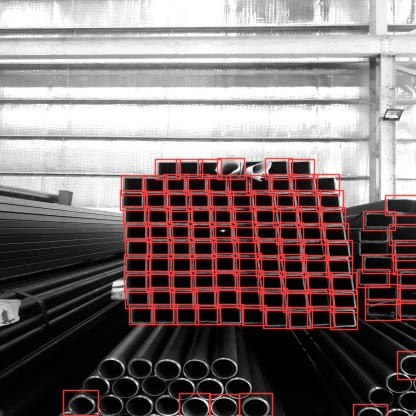

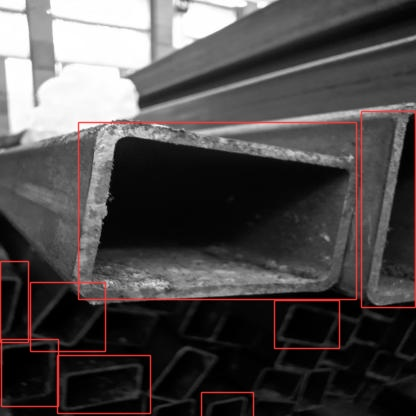

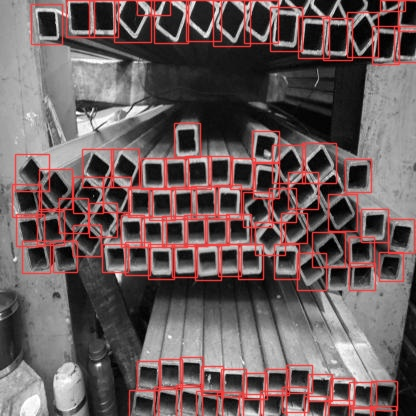

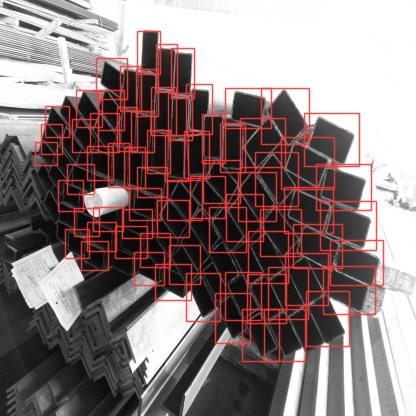

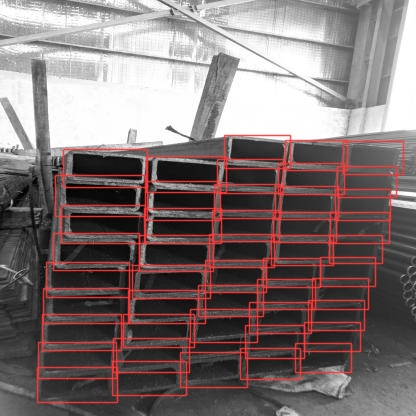

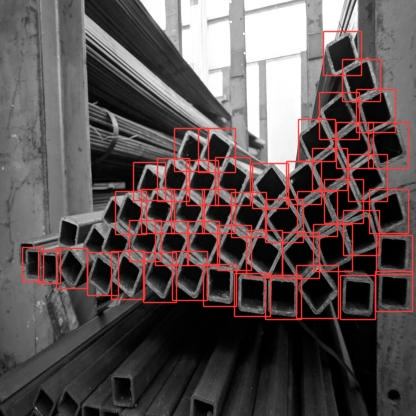

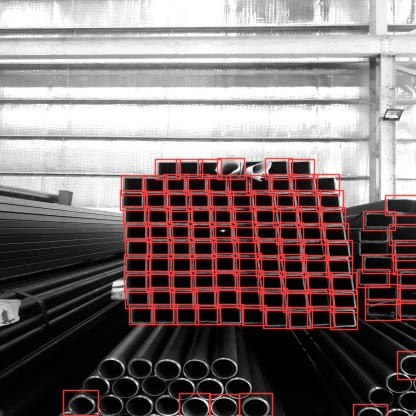

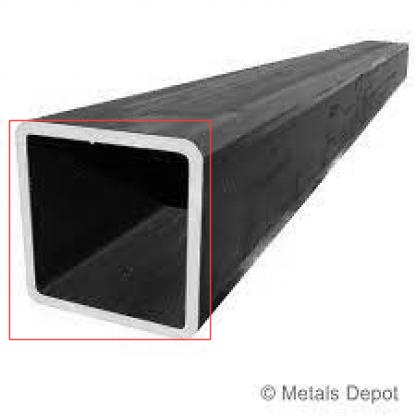

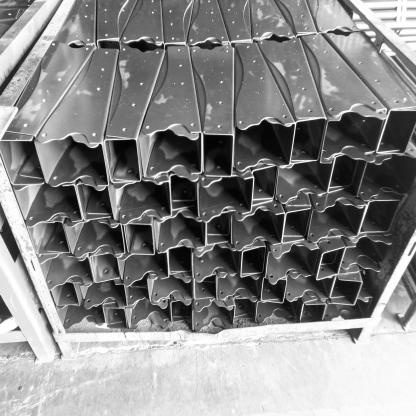

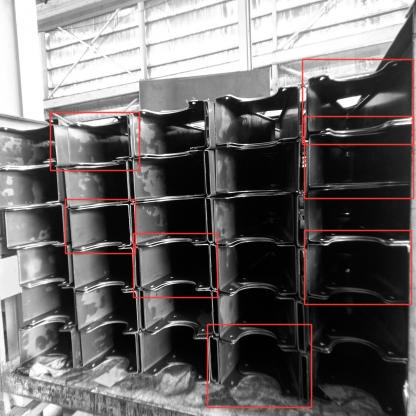

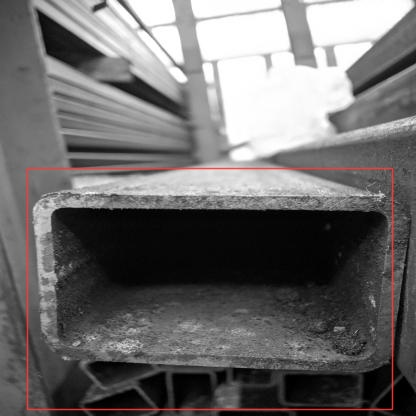

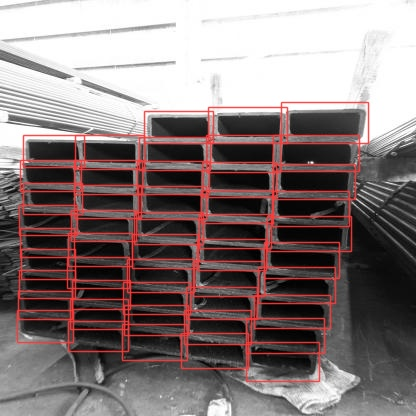

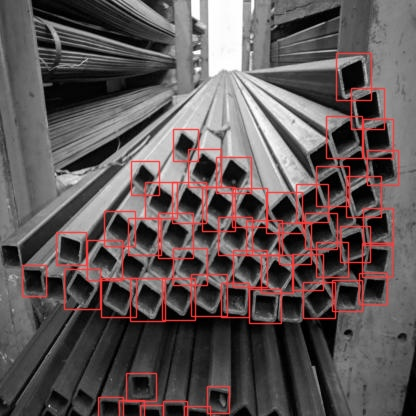

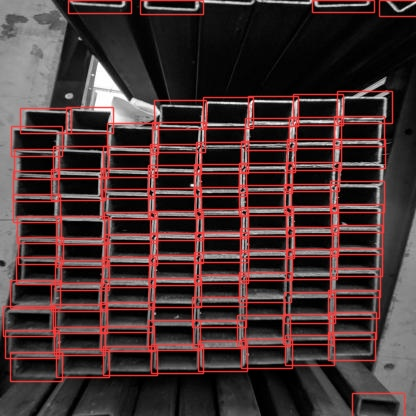

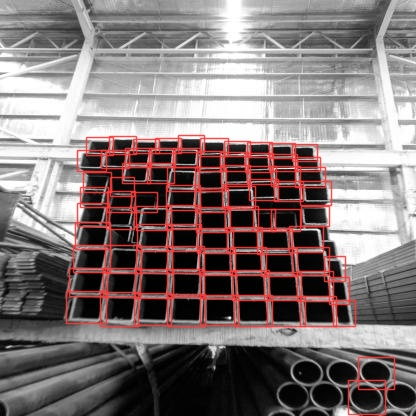

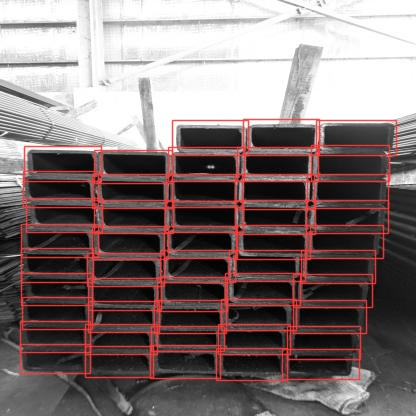

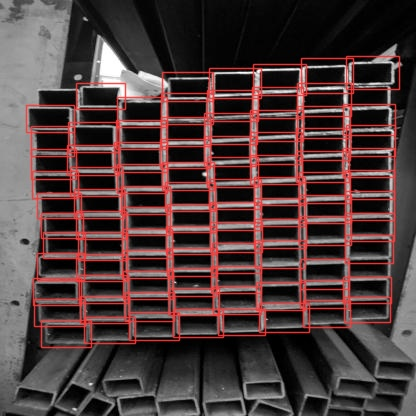

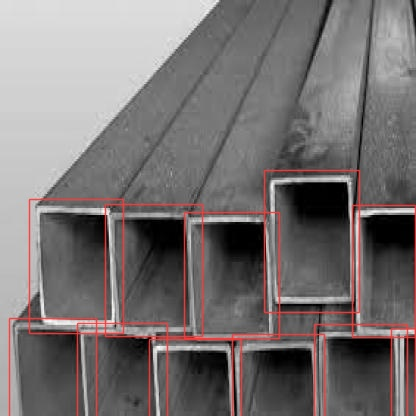

In [15]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/home/serverai/Quick_deeplearning/yolov5/runs/detect/exp13/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

## Export Trained Weights for Future Inference
Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cp /content/yolov5/runs/train/exp/weights/best.pt /content/gdrive/My\ Drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
class Geeks:
  def __init__(self, name1 = "Arun", num2 = 46, name3 = "Rishab"):
    self.name1 = name1
    self.num2 = num2
    self.name3 = name3
    
# GeeksforGeeks = Geeks()
print(vars(Geeks()))

{'name1': 'Arun', 'num2': 46, 'name3': 'Rishab'}
